In [ ]:
# %%

# %load_ext autoreload
# %autoreload 2

In [ ]:
# %%

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from tqdm.auto import trange
from utils import (
    ClassEncoder,
    NaivePredictor,
    char_tokenizer,
    save_json,
    save_pickle,
    set_seed,
    subword_tokenizer,
    unigram_tokenizer,
)

/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %%

hf_ds = load_dataset("MartinThoma/wili_2018")

tr_df = hf_ds["train"].to_pandas()
ts_df = hf_ds["test"].to_pandas()

In [ ]:
# %%

tr_df["label_str"] = tr_df["label"].apply(
    lambda x: hf_ds["train"].info.features["label"].int2str(x)
)
ts_df["label_str"] = ts_df["label"].apply(
    lambda x: hf_ds["test"].info.features["label"].int2str(x)
)

In [ ]:
# %%

char_set = set()
for x in tr_df["sentence"]:
    for xx in x:
        char_set.add(xx)

print(f"{len(char_set)=}")

len(char_set)=10806


In [ ]:
# %%

lang_encoder = ClassEncoder(tr_df["label_str"])
langs_detector = {}
acceptable_f1 = 0.8
seed = 1324809
set_seed(seed=seed)

In [ ]:
# %%

char_predictor = NaivePredictor(tokenize_fn=char_tokenizer, lang_encoder=lang_encoder)
char_predictor.fit(tr_df)


iloc = 0
print(
    "char predictor test:",
    char_predictor.predict([tr_df.iloc[iloc]["sentence"]]),
    "label:",
    tr_df.iloc[iloc]["label_str"],
)

build token to langs mapping
build token-langs similarity matrix
char predictor test: ['orm'] label: est


In [ ]:
# %%

W = 1000
preds = [
    res
    for i in trange(0, ts_df.shape[0], W)
    for res in char_predictor.predict(ts_df["sentence"].values[i : i + W])
]

report = classification_report(ts_df["label_str"], preds)
print(report)
report = pd.DataFrame(
    classification_report(ts_df["label_str"], preds, output_dict=True)
).T
report = report[report.index.isin(lang_encoder.stoi)]

100%|██████████| 118/118 [00:10<00:00, 10.75it/s]
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

              precision    recall  f1-score   support

         ace       0.00      0.00      0.00       500
         afr       0.33      0.00      0.00       500
         als       1.00      0.00      0.01       500
         amh       0.99      0.99      0.99       500
         ang       1.00      0.88      0.94       500
         ara       0.75      0.96      0.84       500
         arg       0.00      0.00      0.00       500
         arz       0.00      0.00      0.00       500
         asm       1.00      0.97      0.98       500
         ast       0.58      0.10      0.16       500
         ava       0.99      0.24      0.38       500
         aym       0.00      0.00      0.00       500
         azb       0.96      0.05      0.09       500
         aze       0.85      0.98      0.91       500
         bak       0.69      0.97      0.81       500
         bar       0.00      0.00      0.00       500
         bcl       0.00      0.00      0.00       500
   be-tarask       0.50    

/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

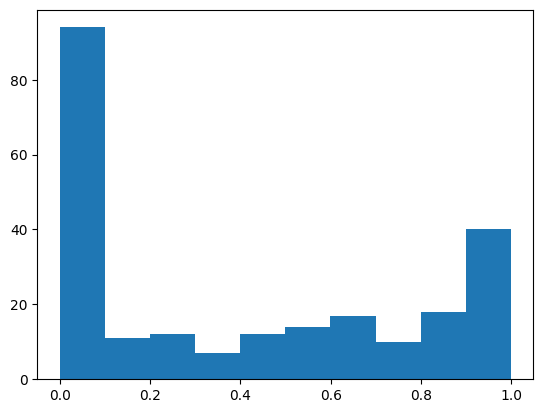

lanuguages detected with chars: 58


In [ ]:
# %%

plt.hist(report["f1-score"])
plt.show()

print(
    "lanuguages detected with chars:",
    (report["f1-score"].sort_values(ascending=False) >= acceptable_f1).sum(),
)

for lang in report[report["f1-score"] >= acceptable_f1].index:
    langs_detector[lang] = "char"

char_predictor.save("data/char-model")

In [ ]:
# %%

remaining_langs = set(report[report["f1-score"] <= 0.8].index.values)
curr_tr_df = tr_df[tr_df["label_str"].isin(remaining_langs)]
curr_ts_df = ts_df[ts_df["label_str"].isin(remaining_langs)]

In [ ]:
# %%

unigram_predictor = NaivePredictor(unigram_tokenizer, lang_encoder)
unigram_predictor.fit(curr_tr_df)

unigram_predictor.predict([curr_tr_df.iloc[0]["sentence"]])  # test

build token to langs mapping
build token-langs similarity matrix


['est']

In [ ]:
# %%

W = 1000
preds = [
    res
    for i in trange(0, curr_ts_df.shape[0], W)
    for res in unigram_predictor.predict(curr_ts_df["sentence"].values[i : i + W])
]

report = classification_report(curr_ts_df["label_str"], preds)
print(report)
report = pd.DataFrame(
    classification_report(curr_ts_df["label_str"], preds, output_dict=True)
).T
report = report[report.index.isin(lang_encoder.stoi)]

100%|██████████| 89/89 [00:05<00:00, 15.26it/s]


              precision    recall  f1-score   support

         ace       0.92      0.99      0.95       500
         afr       0.97      1.00      0.98       500
         als       0.97      0.95      0.96       500
         arg       0.99      0.99      0.99       500
         arz       0.97      1.00      0.98       500
         ast       0.96      0.97      0.97       500
         ava       0.90      0.77      0.83       500
         aym       0.99      0.95      0.97       500
         azb       0.99      1.00      1.00       500
         bar       0.97      0.88      0.92       500
         bcl       0.99      0.97      0.98       500
   be-tarask       0.84      0.92      0.88       500
         bel       0.91      0.81      0.85       500
         ben       0.98      0.92      0.95       500
         bho       0.99      0.95      0.97       500
         bjn       0.97      0.92      0.94       500
         bos       0.67      0.73      0.70       500
         bpy       1.00    

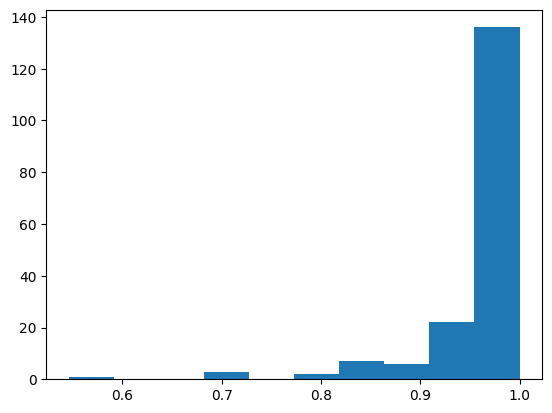

lanuguages detected with unigrams: 173


In [ ]:
# %%

plt.hist(report["f1-score"])
plt.show()

print(
    "lanuguages detected with unigrams:",
    (report["f1-score"].sort_values(ascending=False) >= acceptable_f1).sum(),
)


for lang in report[report["f1-score"] >= acceptable_f1].index:
    langs_detector[lang] = "unigram"

unigram_predictor.save("data/unigram-model")

In [ ]:
# %%

remaining_langs = set(report[report["f1-score"] <= 0.8].index.values)
curr_tr_df = tr_df[tr_df["label_str"].isin(remaining_langs)]
curr_ts_df = ts_df[ts_df["label_str"].isin(remaining_langs)]

In [ ]:
# %%

subword_len = 3

subword_predictor = NaivePredictor(
    tokenize_fn=partial(subword_tokenizer, w=subword_len), lang_encoder=lang_encoder
)
subword_predictor.fit(curr_tr_df)

subword_predictor.predict([curr_tr_df.iloc[0]["sentence"]])  # test

build token to langs mapping
build token-langs similarity matrix


['hbs']

In [ ]:
# %%

W = 1000
preds = [
    res
    for i in trange(0, curr_ts_df.shape[0], W)
    for res in subword_predictor.predict(curr_ts_df["sentence"].values[i : i + W])
]

report = classification_report(curr_ts_df["label_str"], preds)
print(report)
report = pd.DataFrame(
    classification_report(curr_ts_df["label_str"], preds, output_dict=True)
).T
report = report[report.index.isin(lang_encoder.stoi)]

print(
    "lanuguages detected with subwords:",
    (report["f1-score"].sort_values(ascending=False) >= acceptable_f1).sum(),
)

for lang in report[report["f1-score"] >= acceptable_f1].index:
    langs_detector[lang] = "subword"

subword_predictor.save("data/subword-model")

100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

              precision    recall  f1-score   support

         bos       0.66      0.68      0.67       500
         eng       0.93      1.00      0.96       500
         hbs       0.62      0.70      0.66       500
         hrv       0.72      0.55      0.62       500

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000

lanuguages detected with subwords: 1


In [ ]:
# %%

remaining_langs = set(report[report["f1-score"] < acceptable_f1].index.values)

mask = [
    preds[i] in remaining_langs or curr_ts_df["label_str"].iloc[i] in remaining_langs
    for i in range(len(preds))
]

preds = np.array(preds)


print(classification_report(curr_ts_df.loc[mask]["label_str"], preds[mask]))

              precision    recall  f1-score   support

         bos       0.66      0.68      0.67       500
         eng       0.00      0.00      0.00         0
         hbs       0.62      0.70      0.66       500
         hrv       0.72      0.55      0.62       500

    accuracy                           0.64      1500
   macro avg       0.50      0.48      0.49      1500
weighted avg       0.67      0.64      0.65      1500



/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/miniconda3/envs/ukp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


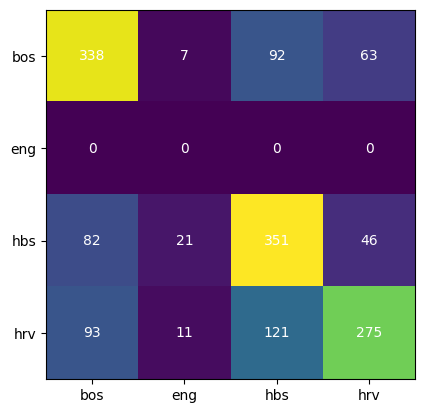

In [ ]:
# %%

temp_labels = sorted(
    set(list(curr_ts_df.loc[mask]["label_str"].unique()) + list(preds[mask]))
)
conf_matrix = confusion_matrix(
    curr_ts_df.loc[mask]["label_str"], preds[mask], labels=temp_labels
)

fig, ax = plt.subplots()
ax.imshow(conf_matrix)
ax.set_xticks(np.arange(len(temp_labels)), labels=temp_labels)  # pred
ax.set_yticks(np.arange(len(temp_labels)), labels=temp_labels)  # true

for i in range(len(temp_labels)):
    for j in range(len(temp_labels)):
        text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="w")
plt.show()

In [ ]:
# %%

curr_tr_df = tr_df[tr_df["label_str"].isin(remaining_langs)]
curr_ts_df = ts_df[ts_df["label_str"].isin(remaining_langs)]

In [ ]:
# %%

tfidf_model = TfidfVectorizer(
    lowercase=True,
    min_df=1,
    use_idf=True,
    ngram_range=(1, 1),
)
X = tfidf_model.fit_transform(curr_tr_df["sentence"])

print(X.shape)

logistic_model = LogisticRegression(C=100)
logistic_model.fit(X, curr_tr_df["label_str"])

print("predicting")
X_ts = tfidf_model.transform(curr_ts_df["sentence"])
preds = logistic_model.predict(X_ts)

report = classification_report(curr_ts_df["label_str"], preds)
print(report)
report = pd.DataFrame(
    classification_report(curr_ts_df["label_str"], preds, output_dict=True)
).T

(1500, 28960)
predicting
              precision    recall  f1-score   support

         bos       0.78      0.76      0.77       500
         hbs       0.76      0.72      0.74       500
         hrv       0.73      0.78      0.75       500

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500



In [ ]:
# %%

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    activation="relu",
    learning_rate_init=1e-3,
)

mlp_model.fit(X, curr_tr_df["label_str"])

print("predicting")
preds = mlp_model.predict(X_ts)

report = classification_report(curr_ts_df["label_str"], preds)
print(report)
report = pd.DataFrame(
    classification_report(curr_ts_df["label_str"], preds, output_dict=True)
).T
report = report[report.index.isin(lang_encoder.stoi)]

print("lanuguages detected with mlp classifier:", report.shape[0])

for lang in report.index:
    langs_detector[lang] = "mlp"

save_pickle(mlp_model, "data/mlp-model")

predicting
              precision    recall  f1-score   support

         bos       0.78      0.81      0.79       500
         hbs       0.78      0.77      0.78       500
         hrv       0.79      0.78      0.79       500

    accuracy                           0.78      1500
   macro avg       0.78      0.78      0.78      1500
weighted avg       0.78      0.78      0.78      1500

lanuguages detected with mlp classifier: 3


In [ ]:
# %%

save_json(langs_detector, "data/langs-detector.json")

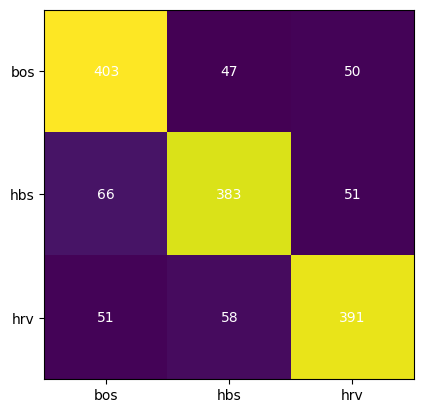

In [ ]:
# %%

temp_labels = sorted(set(list(curr_ts_df["label_str"].unique()) + list(preds)))
conf_matrix = confusion_matrix(curr_ts_df["label_str"], preds, labels=temp_labels)

fig, ax = plt.subplots()
ax.imshow(conf_matrix)
ax.set_xticks(np.arange(len(temp_labels)), labels=temp_labels)  # pred
ax.set_yticks(np.arange(len(temp_labels)), labels=temp_labels)  # true

for i in range(len(temp_labels)):
    for j in range(len(temp_labels)):
        text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="w")
plt.show()

In [ ]:
# %%

print(curr_ts_df[(preds == "bos") & (curr_ts_df["label_str"] == "bos")])

# I checked some 'hbs' and 'hrv' languages in the google translate. all of them were crotian. maybe it is also hard for google to detect it they are same langs and it is the problem of the datset

# bos but google detected crotians:
# U periodu do 9. vijeka brojna mala kraljevstva...
# Rodio se u Zürichu, Švicarska gdje je na ETH p...
# Prva procjena Michaela Todda za proračun filma...
# Američka mornarica je tako razvila i posebnu...
# Terorizam je smišljena upotreba nezakonitog...
# Interni monolog: kada glumac priča kao da se o...

# bos but correctly predicted and google disagreed:
# Ovo sve ukazuje na to da je velika mogučnost ...
# Suprotno uvriježenom mišljenju, velika većina ...
# Košljoribe su su primitivna ektotermne (hladnokrvne), ...

# google agreed on bos:
# Modernizovana verzija Leopard 2 tenka, modernizovana ...

                                                 sentence  label label_str
464     Modernizovana verzija Leopard 2 tenka, moderni...     52       bos
571     Suprotno uvriježenom mišljenju, velika većina ...     52       bos
603     Reakcioni presjek σ je mjera vjerovatnoće fuzi...     52       bos
906     Polupropusna membrana je membrana koja dozvolj...     52       bos
1219    2010. godine dr. Čolakoviću je posthumno dodje...     52       bos
...                                                   ...    ...       ...
115780  Tim istraživača kojeg su predvodili Johannes K...     52       bos
116156  Ovo sve ukazuje na to da je velika mogučnost d...     52       bos
116740  Leopard 2A4CHL – je nadograđena verzija čilean...     52       bos
117178  Trema ( ˙˙ ) pokazuje samostalnost slova nad k...     52       bos
117345  Košljoribe su su primitivna ektotermne (hladno...     52       bos

[403 rows x 3 columns]
